## Dependencies

In [1]:
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

import torch_geometric.transforms as T
from torch_geometric.datasets import SNAPDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv
from torch_geometric.utils import negative_sampling, to_networkx

torch.manual_seed(0)

%matplotlib notebook

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

orig_transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
])

transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        add_negative_train_samples=False
    ),
])

orig_dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=orig_transform)
dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=transform)

data = orig_dataset[0]
train_data, val_data, test_data = dataset[0]

In [3]:
print(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[2432], edge_label_index=[2, 2432])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[284], edge_label_index=[2, 284])
Data(x=[347, 1406], edge_index=[2, 5148], circle=[325], circle_batch=[325], edge_label=[570], edge_label_index=[2, 570])


## Prediction

In [4]:
from torch import nn
import torch.nn.functional as F


class SimpleNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def forward(self, x, edge_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_index)
        return torch.hstack((-out, out)).T


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # TODO: look into SAGEConv, GATConv, GINConv, comparison between
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        self.W1 = nn.Linear(out_channels * 2, out_channels)
        self.W2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        z1 = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), dim=1)
        out1 = self.W2(F.relu(self.W1(z1)).squeeze())
        
        z2 = torch.cat((z[edge_label_index[1]], z[edge_label_index[0]]), dim=1)
        out2 = self.W2(F.relu(self.W1(z2)).squeeze())
        
        return (out1 + out2) / 2
    
    def forward(self, x, edge_index, edge_label_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_label_index)
        return torch.hstack((-out, out)).T

simple_model = SimpleNet(dataset.num_features, 128, 32).to(device)
simple_optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=3e-3)
    
model = Net(dataset.num_features, 128, 32).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# TODO: These methods simultaneously use node feature and graph structure properties.
#       Is it possible to train models that look at each aspect separately
#       Can look at only node features by just passing original layer to MLP
#       Unsure if can look at only graph by passing random vector into GCNConv
#       Should also read up on Node2Vec and other methods of generating node embeddings (talk to Rex)

In [5]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, 
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.shape[1], 
        method='sparse'
    )
    
    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    a, b = data.edge_label.cpu().numpy(), out.cpu().numpy()
    c = (out > 0.5).float().cpu().numpy()
    return roc_auc_score(a, b), accuracy_score(a, c)

In [6]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(simple_model, simple_optimizer, train_data)
    val_auc, val_acc = test(simple_model, val_data)
    test_auc, test_acc = test(simple_model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

simple_z = simple_model.encode(test_data.x, test_data.edge_index)
simple_final_edge_index = simple_model.decode(simple_z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4870, Val: 0.9228 0.7746, Test: 0.8761 0.7298
Epoch: 100, Loss: 0.4653, Val: 0.9349 0.7746, Test: 0.8850 0.7333
Epoch: 150, Loss: 0.4544, Val: 0.9381 0.7711, Test: 0.8925 0.7298
Epoch: 200, Loss: 0.4413, Val: 0.9313 0.7923, Test: 0.8898 0.7386
Epoch: 250, Loss: 0.4368, Val: 0.9234 0.7817, Test: 0.8907 0.7561
Epoch: 300, Loss: 0.4203, Val: 0.9216 0.7923, Test: 0.8846 0.7474
Epoch: 350, Loss: 0.4203, Val: 0.9099 0.7817, Test: 0.8792 0.7439
Epoch: 400, Loss: 0.4284, Val: 0.9191 0.7887, Test: 0.8852 0.7509
Epoch: 450, Loss: 0.4306, Val: 0.9170 0.7887, Test: 0.8833 0.7667
Epoch: 500, Loss: 0.4261, Val: 0.9166 0.7993, Test: 0.8828 0.7596
Epoch: 550, Loss: 0.4284, Val: 0.9121 0.7958, Test: 0.8766 0.7561
Epoch: 600, Loss: 0.4100, Val: 0.9149 0.8169, Test: 0.8744 0.7614
Epoch: 650, Loss: 0.4130, Val: 0.9091 0.8239, Test: 0.8702 0.7702
Epoch: 700, Loss: 0.4277, Val: 0.9015 0.8099, Test: 0.8736 0.7667
Epoch: 750, Loss: 0.3977, Val: 0.9092 0.8204, Test: 0.8729 0.7561
Epoch: 800

In [7]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(model, optimizer, train_data)
    val_auc, val_acc = test(model, val_data)
    test_auc, test_acc = test(model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode(z, test_data.edge_label_index)

Epoch: 050, Loss: 0.3890, Val: 0.9384 0.8521, Test: 0.8958 0.8175
Epoch: 100, Loss: 0.3061, Val: 0.9488 0.8627, Test: 0.9273 0.8544
Epoch: 150, Loss: 0.2737, Val: 0.9557 0.8838, Test: 0.9288 0.8544
Epoch: 200, Loss: 0.2668, Val: 0.9587 0.8768, Test: 0.9272 0.8596
Epoch: 250, Loss: 0.2617, Val: 0.9590 0.8838, Test: 0.9265 0.8526
Epoch: 300, Loss: 0.2561, Val: 0.9606 0.8873, Test: 0.9241 0.8474
Epoch: 350, Loss: 0.2526, Val: 0.9611 0.8944, Test: 0.9256 0.8579
Epoch: 400, Loss: 0.2518, Val: 0.9619 0.9085, Test: 0.9248 0.8544
Epoch: 450, Loss: 0.2539, Val: 0.9618 0.8908, Test: 0.9235 0.8544
Epoch: 500, Loss: 0.2409, Val: 0.9612 0.8873, Test: 0.9234 0.8544
Epoch: 550, Loss: 0.2512, Val: 0.9621 0.8944, Test: 0.9232 0.8579
Epoch: 600, Loss: 0.2341, Val: 0.9623 0.9049, Test: 0.9236 0.8614
Epoch: 650, Loss: 0.2342, Val: 0.9619 0.8944, Test: 0.9266 0.8632
Epoch: 700, Loss: 0.2291, Val: 0.9620 0.8979, Test: 0.9272 0.8667
Epoch: 750, Loss: 0.2383, Val: 0.9614 0.9014, Test: 0.9277 0.8719
Epoch: 800

In [8]:
(test_data.edge_label == (torch.sigmoid(simple_final_edge_index.squeeze()) > 0.7)).sum() / test_data.edge_label.shape[0]

tensor(0.8421)

In [9]:
(test_data.edge_label == (torch.sigmoid(final_edge_index.squeeze()) > 0.5)).sum() / test_data.edge_label.shape[0]

tensor(0.8807)

In [10]:
simple_model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[ 0.3655,  0.4223, -0.8247,  ...,  0.9121, -0.0770,  0.3804],
        [-0.3655, -0.4223,  0.8247,  ..., -0.9121,  0.0770, -0.3804]],
       grad_fn=<PermuteBackward0>)

In [11]:
model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[-7.7029, -1.2168, -1.1368,  ...,  5.6064,  6.7981,  5.8243],
        [ 7.7029,  1.2168,  1.1368,  ..., -5.6064, -6.7981, -5.8243]],
       grad_fn=<PermuteBackward0>)

## Exploration

In [12]:
test_data.edge_label_index[:, 12]

tensor([ 24, 187])

In [13]:
node_1 = 24
node_2 = 187

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {256, 129, 2, 269, 270, 271, 275, 147, 276, 20, 279, 25, 282, 157, 30, 289, 290, 38, 39, 168, 169, 296, 175, 50, 55, 184, 185, 64, 321, 66, 322, 324, 68, 198, 71, 199, 72, 330, 75, 331, 335, 82, 83, 87, 346, 220, 93, 223, 97, 230, 231, 103, 102, 104, 235, 236, 238, 112, 245, 121}
Node 2 Neighbors: {257, 2, 132, 8, 12, 141, 270, 271, 273, 276, 20, 279, 25, 155, 284, 29, 289, 290, 164, 296, 169, 303, 175, 55, 184, 185, 314, 321, 322, 66, 199, 74, 333, 78, 207, 84, 341, 222, 103, 238, 112, 118, 121, 251}
Overlapping Neighbors: {2, 270, 271, 276, 20, 279, 25, 289, 290, 296, 169, 175, 55, 184, 185, 321, 322, 66, 199, 103, 238, 112, 121}


<IPython.core.display.Javascript object>


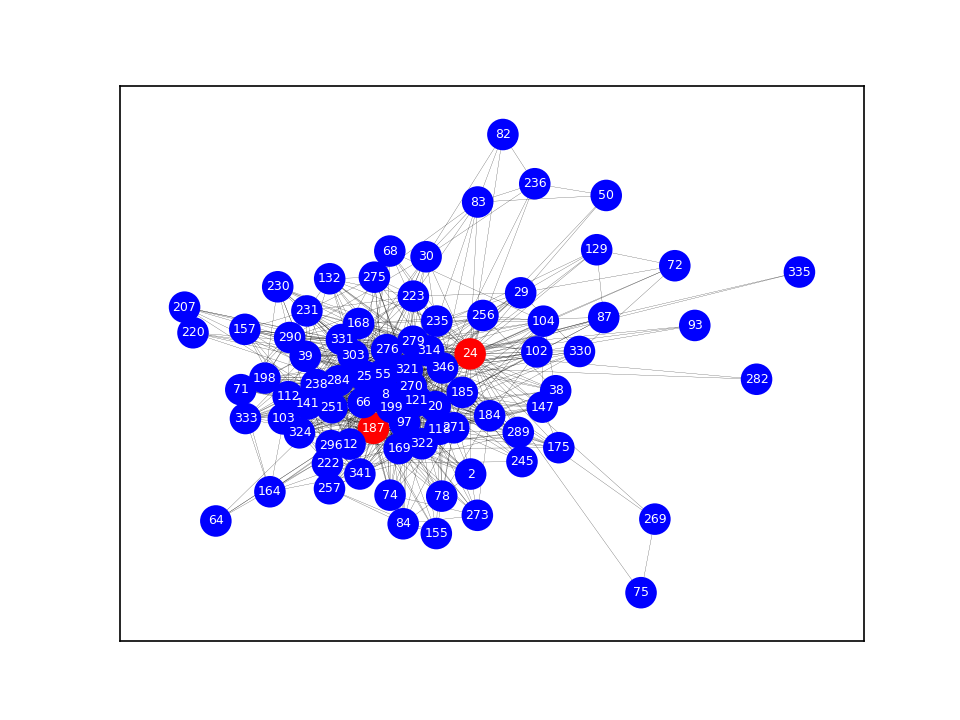

In [14]:
nodes = [node_1, node_2] + list(node_1_neighbors.union(node_2_neighbors))
colors = ["red", "red"] + ["blue" for _ in nodes[2:]]

fig, ax = plt.subplots()
g = to_networkx(test_data, to_undirected=True)
h = g.subgraph(nodes)
nx.draw_networkx(h, node_size=200, nodelist=nodes, node_color=colors, width=0.1, font_color="white", font_size=6)
plt.show()

In [15]:
old_z = model.encode(test_data.x, test_data.edge_index)
old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
print(old_pred)

tensor([4.4176], grad_fn=<DivBackward0>)


In [16]:
for neighbor in node_1_neighbors.union(node_2_neighbors):
    temp_x = test_data.x.clone()
    temp_x[neighbor] = 0
    new_z = model.encode(temp_x, test_data.edge_index)
    new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
    print(neighbor, "\t", round(new_pred.item(), 5))

256 	 4.33323
257 	 4.33871
2 	 4.32448
8 	 4.39076
12 	 4.33888
269 	 4.69283
270 	 4.37758
271 	 4.348
273 	 4.36132
275 	 4.42909
276 	 4.39741
20 	 4.35059
279 	 4.42061
25 	 4.41239
282 	 4.33743
284 	 4.31946
29 	 4.42183
30 	 4.50627
289 	 4.38226
290 	 4.43812
38 	 4.41478
39 	 4.33609
296 	 4.42754
303 	 4.43686
50 	 4.43129
55 	 4.26889
314 	 4.46626
64 	 4.40371
321 	 4.42137
66 	 4.34393
322 	 4.31704
324 	 4.41439
68 	 4.42261
71 	 4.41724
72 	 4.30384
330 	 4.45145
75 	 4.44544
331 	 4.48175
74 	 4.431
333 	 4.41785
335 	 4.44756
78 	 4.45839
82 	 4.53633
83 	 4.45085
84 	 4.4571
341 	 4.41169
87 	 4.47272
346 	 4.19092
93 	 4.41198
97 	 4.41285
102 	 4.43275
103 	 4.37769
104 	 4.50389
112 	 4.37919
118 	 4.51976
121 	 4.38443
129 	 4.41721
132 	 4.39163
141 	 4.38964
147 	 4.44685
155 	 4.26606
157 	 4.39417
164 	 4.41779
168 	 4.39209
169 	 4.34143
175 	 4.37736
184 	 4.40117
185 	 4.40087
198 	 4.33904
199 	 4.42043
207 	 4.51241
220 	 4.40706
222 	 4.39948
223 	 4.34

In [17]:
# Start implementing GNNExplainer, PGExplainer, and SubgraphX architectures with 1-hop subgraph as parameters
# Think about separately learning node feature explanations

## GNNExplainer

In [18]:
from math import sqrt

from torch_geometric.nn import GNNExplainer
from torch_geometric.nn.models.explainer import clear_masks, set_masks
from torch_geometric.utils import k_hop_subgraph

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    coeffs = {
        'edge_size': 0.10,  # 0.005
        'edge_reduction': 'sum',  # sum
        'edge_ent': 1.0,  # 1.0
    }
    
    def _initialize_masks(self, x, edge_index, sub_edge_mask=None, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        self.node_feat_mask = torch.nn.Parameter(100 * torch.ones(1, F))
        
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        if sub_edge_mask is None:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)
        else:
            E_1, mask = sub_edge_mask.sum(), 100 * torch.ones(E)
            mask[sub_edge_mask] = torch.randn(E_1) * std
            self.edge_mask = torch.nn.Parameter(mask)  
    
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction]
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = (
            error_loss + 
            self.coeffs['edge_size'] * edge_size_loss + 
            self.coeffs['edge_ent'] * edge_ent_loss
        )
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    
    """
    # Alternative loss function that tries to simultaneously optimize constraints
    # From qualitative testing, seems to better satisfy both constraints
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction].clip(-6, 6)
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = - (1 - (error_loss + 6) / 12) * (1 - torch.mean(m)) + 0.1 * edge_ent_loss
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    """
    
    def subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        subset_1, edge_index_1, _, edge_mask_1 = k_hop_subgraph(
            node_idx_1, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        subset_2, edge_index_2, _, edge_mask_2 = k_hop_subgraph(
            node_idx_2, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        
        # Combines two node-centered subgraphs
        temp_node_idx = edge_index[0].new_full((num_nodes,), -1)  # full size
        edge_mask = edge_mask_1 | edge_mask_2
        edge_index = edge_index[:, edge_mask]  # filters out edges
        subset = torch.cat((subset_1, subset_2)).unique()
        temp_node_idx[subset] = torch.arange(subset.size(0), device=edge_index.device)
        edge_index = temp_node_idx[edge_index]  # maps edge_index to [0, n]
        x = x[subset]  # filters out nodes
        mapping = torch.tensor([
            (subset == node_idx_1).nonzero().item(), 
            (subset == node_idx_2).nonzero().item(),
        ])
        
        # Only optimizes the edges from neighbors to node_1/node_2, other direction not needed for prediction
        sub_edge_mask = (edge_index[1] == mapping[0]) |  (edge_index[1] == mapping[1])
        
        return x, edge_index, mapping, edge_mask, subset, sub_edge_mask
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        # Only operate on a k-hop subgraph around `node_idx_1` and `node_idx_2.
        x, edge_index, mapping, hard_edge_mask, subset, sub_edge_mask = \
            self.subgraph(node_idx_1, node_idx_2, x, edge_index)
        self.sub_edge_mask = sub_edge_mask
        edge_label_index=mapping.unsqueeze(1)
        
        # Get the initial prediction
        prediction = self.get_initial_prediction(x, edge_index, edge_label_index=edge_label_index)
        
        self._initialize_masks(x, edge_index, sub_edge_mask)
        self.to(x.device)

        set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
        optimizer = torch.optim.Adam([self.edge_mask], lr=self.lr)

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x=x, edge_index=edge_index, edge_label_index=edge_label_index)
            loss = self.get_loss(out, prediction, mapping).mean()
            loss.backward()
            optimizer.step()

        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        
        self._clear_masks()

        return edge_mask

In [19]:
x = test_data.x
edge_index = test_data.edge_index

node_idx_1 = node_1  # test_data.edge_label_index[0, 0].item()
node_idx_2 = node_2  # test_data.edge_label_index[1, 0].item()

print(node_idx_1, node_idx_2)

explainer = EdgeGNNExplainer(model, epochs=200, lr=0.1)
edge_mask = explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

print("Done!")

24 187
0.4638   	 51.6268   	 0.6925   	 6.319   	
0.376   	 51.1787   	 0.6913   	 6.1852   	
0.2881   	 50.737   	 0.6876   	 6.0494   	
0.2377   	 50.3007   	 0.6815   	 5.9493   	
0.2221   	 49.8038   	 0.6743   	 5.8768   	
0.2076   	 49.3056   	 0.6658   	 5.804   	
0.194   	 48.812   	 0.6561   	 5.7313   	
0.2143   	 48.3261   	 0.6453   	 5.6922   	
0.2443   	 47.9588   	 0.6352   	 5.6754   	
0.2597   	 47.7119   	 0.6272   	 5.658   	


C:\Users\Abhijit\AppData\Local\Temp\ipykernel_19764\81617139.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  return torch.hstack((-out, out)).T


0.2507   	 47.5207   	 0.6204   	 5.6232   	
0.2245   	 47.3694   	 0.6147   	 5.5761   	
0.1849   	 47.25   	 0.6096   	 5.5195   	
0.1345   	 47.1579   	 0.605   	 5.4553   	
0.085   	 47.0896   	 0.6007   	 5.3947   	
0.037   	 47.0506   	 0.596   	 5.3382   	
0.0221   	 46.9806   	 0.5898   	 5.31   	
0.0077   	 46.8851   	 0.5823   	 5.2785   	
-0.0063   	 46.7692   	 0.5738   	 5.2444   	
-0.0197   	 46.6372   	 0.5644   	 5.2084   	
-0.0324   	 46.4928   	 0.5542   	 5.1711   	
-0.0446   	 46.3392   	 0.5435   	 5.1329   	
-0.056   	 46.1791   	 0.5323   	 5.0942   	
-0.0668   	 46.0145   	 0.5207   	 5.0554   	
-0.0768   	 45.8472   	 0.5088   	 5.0168   	
-0.0846   	 45.6785   	 0.4968   	 4.98   	
-0.0888   	 45.5293   	 0.4848   	 4.949   	
-0.0943   	 45.3985   	 0.473   	 4.9186   	
-0.1011   	 45.2851   	 0.4614   	 4.8889   	
-0.1089   	 45.188   	 0.45   	 4.8599   	
-0.1178   	 45.1062   	 0.4388   	 4.8316   	
-0.1275   	 45.0385   	 0.4277   	 4.8041   	
-0.138   	 4

-0.4337   	 44.8933   	 0.0318   	 4.0874   	
-0.4337   	 44.8919   	 0.0316   	 4.0871   	
-0.4337   	 44.8914   	 0.0313   	 4.0867   	
-0.4338   	 44.8916   	 0.031   	 4.0863   	
-0.4339   	 44.8916   	 0.0307   	 4.086   	
-0.4339   	 44.8914   	 0.0304   	 4.0856   	
-0.434   	 44.891   	 0.0302   	 4.0853   	
Done!


In [20]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_2)], edge_mask[(edge_index[1] == node_idx_2)])
).T

tensor([[1.3200e+02, 9.9453e-01],
        [1.1200e+02, 2.5047e-03],
        [8.4000e+01, 9.9603e-01],
        [1.8400e+02, 2.8862e-03],
        [1.0300e+02, 1.9256e-03],
        [1.8500e+02, 1.7330e-03],
        [1.6900e+02, 2.1985e-03],
        [7.8000e+01, 9.9724e-01],
        [1.2000e+01, 3.8276e-02],
        [2.9000e+01, 9.9605e-01],
        [2.0000e+01, 4.1283e-03],
        [6.6000e+01, 1.9592e-03],
        [2.5000e+01, 1.7913e-03],
        [1.4100e+02, 9.9806e-01],
        [1.7500e+02, 9.9822e-01],
        [1.2100e+02, 5.3130e-03],
        [1.6400e+02, 9.9632e-01],
        [1.5500e+02, 9.9526e-01],
        [8.0000e+00, 2.5719e-03],
        [2.0000e+00, 9.9785e-01],
        [7.4000e+01, 9.9787e-01],
        [5.5000e+01, 2.3639e-03],
        [1.1800e+02, 9.9378e-01],
        [2.8400e+02, 9.9617e-01],
        [2.5700e+02, 9.9640e-01],
        [2.9000e+02, 2.2927e-03],
        [2.7000e+02, 2.1911e-03],
        [2.9600e+02, 2.5521e-03],
        [2.2200e+02, 9.9360e-01],
        [2.760

In [21]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_1)], edge_mask[(edge_index[1] == node_idx_1)])
).T

tensor([[2.0000e+01, 2.6691e-03],
        [2.0000e+00, 9.9807e-01],
        [3.9000e+01, 1.5113e-03],
        [3.4600e+02, 5.7498e-03],
        [3.8000e+01, 9.9719e-01],
        [7.1000e+01, 9.9836e-01],
        [7.5000e+01, 9.2586e-01],
        [5.5000e+01, 2.1944e-03],
        [2.9000e+02, 1.9240e-03],
        [3.2400e+02, 9.9628e-01],
        [2.2300e+02, 3.0106e-03],
        [6.4000e+01, 9.9656e-01],
        [2.4500e+02, 5.3014e-03],
        [2.3800e+02, 9.9603e-01],
        [2.3100e+02, 2.1596e-03],
        [1.9800e+02, 9.9690e-01],
        [6.8000e+01, 9.9110e-01],
        [3.3500e+02, 3.1007e-03],
        [5.0000e+01, 3.0659e-03],
        [1.8400e+02, 2.2485e-03],
        [3.3000e+02, 9.9568e-01],
        [3.0000e+01, 2.6768e-03],
        [1.9900e+02, 1.8943e-03],
        [1.8500e+02, 1.8342e-03],
        [1.0300e+02, 1.7889e-03],
        [2.3500e+02, 2.2777e-03],
        [2.5000e+01, 1.6293e-03],
        [9.3000e+01, 3.5300e-02],
        [1.5700e+02, 5.1132e-03],
        [2.820

In [22]:
display(edge_index[:, (edge_index[1] == 187)])
edge_index[:, (edge_mask > 0.5) & (edge_mask < 1) & (edge_index[1] == 187)]

tensor([[132, 112,  84, 184, 103, 185, 169,  78,  12,  29,  20,  66,  25, 141,
         175, 121, 164, 155,   8,   2,  74,  55, 118, 284, 257, 290, 270, 296,
         222, 276, 321, 341, 251, 199, 207, 322, 271, 289, 273, 303, 279, 333,
         314, 238],
        [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187]])

tensor([[132,  84,  78,  29, 141, 175, 164, 155,   2,  74, 118, 284, 257, 222,
         341, 207, 322, 271, 289, 273, 314],
        [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187]])

In [23]:
display(edge_index[:, (edge_index[1] == 24)])
edge_index[:, (edge_mask > 0.5) & (edge_mask < 1) & (edge_index[1] == 24)]

tensor([[ 20,   2,  39, 346,  38,  71,  75,  55, 290, 324, 223,  64, 245, 238,
         231, 198,  68, 335,  50, 184, 330,  30, 199, 185, 103, 235,  25,  93,
         157, 282,  97, 230, 121, 256, 168, 270, 269, 331, 175, 169,  82,  72,
         321, 112, 289, 275,  66,  83, 322, 147, 236, 102, 296, 276,  87, 129,
         220, 279, 104, 271],
        [ 24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24]])

tensor([[  2,  38,  71,  75, 324,  64, 238, 198,  68, 330, 282,  97, 230, 256,
         269, 169,  72, 112, 289,  83, 102,  87, 129, 220],
        [ 24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24]])

In [24]:
edge_mask[(edge_mask > 0) & (edge_mask < 1)].mean()

tensor(0.4316)

Methods to produce explanations
- GNNExplainer with the prediction model outputting probability, optimizing edge weights directed into node 1/2
  - Need to look into better combination of loss terms
  - Should explore using separate node embedding regression explanation
  - (To isolate graph explanation) can potentially set node 1/2 features to 0, or remove edges from node 1/2 (preferred?)
- SubgraphX variants (including just using 'Algorithm 2' on each of the candidate nodes, since the subgraph tree concept is less applicable)